# KE budget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_offline_runs

In [3]:
yp = YAMLParser()

In [4]:
# read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl10
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHGL300_hbbldyn
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 12.1 s, sys: 1.72 s, total: 13.8 s
Wall time: 2min 21s


In [5]:
# read offline diags
exps_offline = yp.read('/glade/u/home/noraloose/GL90paper/config_offline.yaml')
%time exps_offline = read_offline_runs(exps_offline)

CPU times: user 4.01 s, sys: 1.88 s, total: 5.89 s
Wall time: 10.9 s


### Bottom drag contribution

In [6]:
vlist = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
]

In [7]:
%%time

for v in vlist:
    print(v['label'])
    ds = v['ds']
    grid = v['grid']
    
    # accumulate layer thicknesses from bottom upward
    # do cumulative sum in numpy for now
    h_rev = ds['h'].values[:,::-1,...]
    h_cum = np.cumsum(h_rev, axis=1)
    h_cum_layer = h_cum[:,::-1,...]
    h_cum_layer = xr.DataArray(h_cum_layer, coords=ds.h.coords, dims=ds.h.dims)

    frac = (h_cum_layer - grid.interp(ds.bbl_thick_u, 'X')) / ds.h
    frac = xr.where(frac < 0, 1, frac)  # if frac < 0, then layer is completely contained in BBL
    frac = xr.where(frac > 1, 0, frac)  # if frac > 1, then layer is completely contained outside of BBL
    # contribution from all layers that are completely contained in BBL:
    ds['KE_bottom_drag'] = ds['KE_visc'] * frac

1/2$^\circ$ GM 800
1/2$^\circ$ GL 800 hbbl 5
1/4$^\circ$ GM 300
1/4$^\circ$ GL 300 hbbl 5
1/8$^\circ$ GM 100
1/8$^\circ$ GL 100 hbbl 5
CPU times: user 2min 30s, sys: 51.8 s, total: 3min 22s
Wall time: 6min 37s


### Prepare KE budget

In [8]:
for v in vlist:
            ds = v['ds']
            st = v['st']
            grid = v['grid']

            ds['PE_to_KE+KE_BT'] = ds['PE_to_KE'] + ds['KE_BT']
            ds['KE_visc_no_wind_no_drag'] = ds['KE_visc'] - ds['KE_visc_gl90'] - ds['KE_stress'] - ds['KE_bottom_drag']

## Time-average data

In [9]:
for v in vlist:
        ds = v['ds']
        dst = ds.mean(dim='time', keep_attrs=True)
        if 'dst' in v: # some experiments have pre-computed time averaged fields
            for field in v['dst'].data_vars:
                dst[field] = v['dst'][field]
        v['dst'] = dst

# Plots

In [10]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 14}
from matplotlib import pylab
pylab.rcParams.update(params)
from matplotlib.ticker import MultipleLocator

## Bar plots

In [11]:
explist = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
]
fldlist = ['KE_adv','PE_to_KE+KE_BT','KE_horvisc','KE_stress', 'KE_bottom_drag', 'KE_visc_gl90', 'KE_visc_no_wind_no_drag']

with ProgressBar():
    for exp in explist:
        print(exp['label'])
        dst = exp['dst']
        for fld in fldlist:
            dst[fld].load()

1/2$^\circ$ GM 800
[########################################] | 100% Completed | 21.4s
[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 20.4s
[########################################] | 100% Completed |  1min  5.0s
[########################################] | 100% Completed | 21.3s
[########################################] | 100% Completed |  1min 16.5s
1/2$^\circ$ GL 800 hbbl 5
[########################################] | 100% Completed | 21.8s
[########################################] | 100% Completed | 25.6s
[########################################] | 100% Completed | 22.9s
[########################################] | 100% Completed | 19.9s
[########################################] | 100% Completed |  1min  2.6s
[########################################] | 100% Completed | 21.8s
[########################################] | 100% Com

In [18]:
def bar_plot_KE_budget(vlist, label_list, abc_list=['(a)','(b)','(c)'], title='', ylim=5e8):

    fldlist = ['KE_adv','PE_to_KE+KE_BT','KE_horvisc','KE_stress', 'KE_bottom_drag', 'KE_visc_gl90', 'KE_visc_no_wind_no_drag']
    labellist = ['Advection of KE', 'Conversion to PE', 'Horizontal friction work', 'Wind work', 'Bottom drag', 
                 'GL90 work', 'Vertical friction work']
    colorlist = ['k', '#f0027f','#7fc97f', '#ffff99', '#beaed4', '#386cb0','#f7f7f7']
    
    fig,ax = plt.subplots(1,1,figsize=(17,6))

    width = 0.15
    
    if len(vlist) == 4:
        X = np.array([0, 2, 4, 6])
        xticks = [1, 3, 5, 7]
        xlim = 8
    elif len(vlist) == 2:
        X = np.array([0, 2])
        xticks = [1, 3]
        xlim = 4
    elif len(vlist) == 3:
        X = np.array([0, 2, 4])
        xticks = [1, 3, 5]
        xlim = 6

    label = 'Wind work'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = v['dst_energy']['MKE_wind_stress_TWA']
        else:
            fld = v['dst']['KE_stress'].sum(dim='zl')

        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)
    ax.bar(X + 0.3, integral_list, color='#4daf4a', label=label, width=width)

    label = 'GL90 work' 
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = 0 * v['dst_energy']['EKE_production_TWA']
        else:
            fld = v['dst']['KE_visc_gl90'].sum(dim='zl')
            
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)
    
    ax.bar(X + 0.5, integral_list, color='#f781bf', label=label, width=width)
    
    label = 'Work by eddy form stress' 
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = -v['dst_energy']['EKE_production_TWA']
        else:
            fld = 0 * v['dst']['KE_visc_gl90'].sum(dim='zl')
            
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)
    
    ax.bar(X + 0.5, integral_list, color='#f781bf', label=label, width=width, hatch=['//', '//', '//'])

    
    label = 'Conversion to PE'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = v['dst_energy']['MKE_to_MPE_TWA']
        else:
            fld = v['dst']['PE_to_KE+KE_BT'].sum(dim='zl')
            
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)

    ax.bar(X + 0.7, integral_list, color='#e41a1c', label=label, width=width)

    label = 'GM work'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = 0 * v['dst_energy']['MKE_to_MPE_TWA']
        else:
            fld = v['dst']['GMwork'] / 1000 # convert from W m-2 to m3s-3
            
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)

    ax.bar(X + 0.9, integral_list, color='#999999', label=label, width=width, hatch=['o','o','o'])

    label = 'Bottom drag' 
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = v['dst_energy']['MKE_bottom_drag_TWA']
        else:
            fld = v['dst']['KE_bottom_drag'].sum(dim='zl')
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)
    
    ax.bar(X + 1.1, integral_list, color='#984ea3', label=label, width=width)

    label = 'Vertical viscosity work'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = v['dst_energy']['MKE_vertical_viscosity_TWA']
        else:
            fld = v['dst']['KE_visc_no_wind_no_drag'].sum(dim='zl')
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)

    ax.bar(X + 1.3, integral_list, color='#ff7f00', label=label, width=width)
    
    label = 'Horizontal viscosity work'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = v['dst_energy']['MKE_horizontal_viscosity_TWA']
        else:
            fld = v['dst']['KE_horvisc'].sum(dim='zl')
            
        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)

    ax.bar(X + 1.5, integral_list, color='#a65628', label=label, width=width)
    
    label = 'nonlinear KE exchange'
    integral_list = []
    for v in vlist:
        if v['param'] == None:
            fld = - v['dst_energy']['work_eddy_momentum_fluxes_TWA']
        else:
            fld = 0 * v['dst']['KE_stress'].sum(dim='zl')

        integral = (fld * v['st']['area_t']).sum(dim=['xh','yh'])
        integral_list.append(integral)
    ax.bar(X + 1.7, integral_list, color='#377eb8', label=label, width=width, hatch=['//', '//', '//'])
        
 
    xspace = 0
    for abc in abc_list:
        ax.text(xspace + 1, 4.3e8, abc, fontsize=20, backgroundcolor='white')
        xspace = xspace + 2

    ax.set_xticks(xticks)
    if len(label_list) == 0:
        for v in vlist:
            label = (v['label'])
            label_list.append(label)

    ax.set_xticklabels(label_list)
    ax.set_xlabel('')

    ax.axvspan(2, 4, facecolor='0.1', alpha=0.05)
    ax.axvspan(4, 6, facecolor='0.1', alpha=0.05)
    
    ax.hlines(0, 0, 8, color='k')
    ax.vlines(2, -ylim, ylim, color='k')
    ax.vlines(4, -ylim, ylim, color='k')
    
    ax.set_xlim([0, xlim])
    ax.minorticks_on()
    ax.grid(axis='y', which='major')
    ax.grid(axis='y', which='minor')
    
    ax.legend(loc='upper right')
    ax.set_yticks(ticks=np.arange(-4, 5, 2)*1e8)
    ax.set_ylim([-ylim, ylim])
    ax.set(yticklabels=['-4', '-2', '0', '2', '4'])
    ax.set(ylabel=r'$\times 10^8$ [m$^5$ s$^{-3}$]')
    ax.yaxis.label.set_size(20)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(labelsize=20)

    ax.legend(bbox_to_anchor=(0.5,-0.2), loc="upper center", fontsize=20, ncol=3)

    plt.subplots_adjust(wspace=1)  

    fig.suptitle(title, y=0.95, x=0.52, fontsize=20)
    
    return fig

### 1/2 degree

In [19]:
vlist = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
    exps_offline['nw2_0.03125deg_N15_baseline_hmix20_fac64']
]
label_list = [
    r'1/2$^\circ$ GM 800',
    r'1/2$^\circ$ GL 800',    
    r'offline "truth"'
]
abc_list =[
    '(a)', '(b)', '(c)'
]
title=r'1/2$^\circ$ simulations'

In [20]:
for v in vlist:
    print(v['label'])
    ds = v['ds']
    #print(len(ds.time))
    #print(ds.time[0].values)
    
    dst = v['dst']
    st = v['st']
    if 'KE_visc_gl90' in dst:
        value = (dst['KE_visc_gl90'].sum(dim='zl') * st.area_t).sum(dim=['xh', 'yh'])
        print('KE_visc_gl90: integral %g' % value)       
    if 'dst_energy' in v:
        dst = v['dst_energy']
        if 'EKE_production_TWA' in dst:
            value = (dst['EKE_production_TWA'] * st.area_t).sum(dim=['xh', 'yh'])
            print('EKE_production_TWA: integral %g' % value)

1/2$^\circ$ GM 800
KE_visc_gl90: integral 7.67841e-10
1/2$^\circ$ GL 800 hbbl 5
KE_visc_gl90: integral -3.28133e+08
1/2$^\circ$ diagnosed
EKE_production_TWA: integral 3.14156e+08


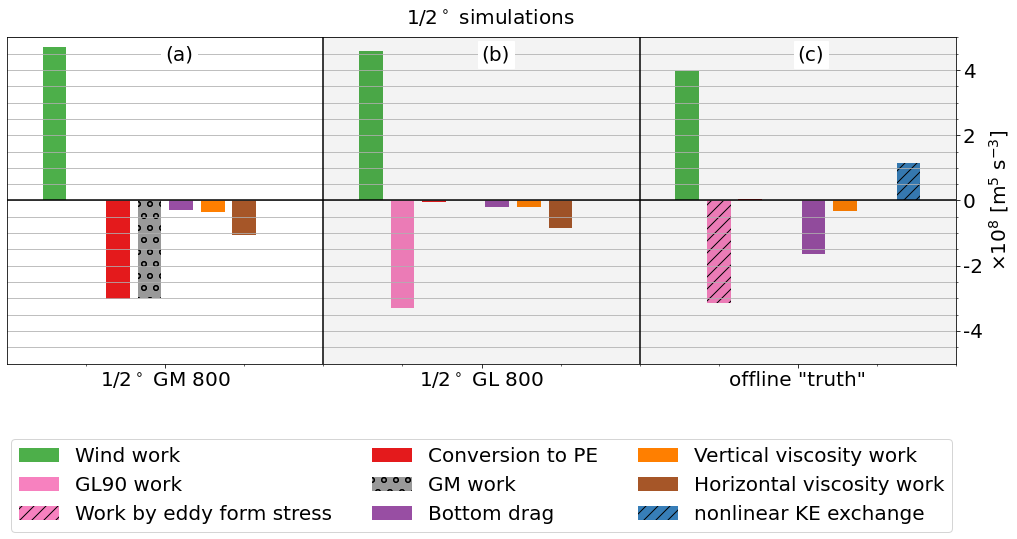

In [21]:
fig = bar_plot_KE_budget(vlist, label_list=label_list, abc_list=abc_list, title=title, ylim=5e8)
figname = '/glade/u/home/noraloose/GL90paper/figures/KE_budget_0.5deg.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree

In [22]:
vlist = [
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_offline['nw2_0.03125deg_N15_baseline_hmix20_fac32']
]
label_list = [
    r'1/4$^\circ$ GM 300',
    r'1/4$^\circ$ GL 300',    
    r'offline "truth"'
]
abc_list =[
    '(d)', '(e)', '(f)'
]
title=r'1/4$^\circ$ simulations'

In [23]:
for v in vlist:
    print(v['label'])
    ds = v['ds']
    #print(len(ds.time))
    #print(ds.time[0].values)
    
    dst = v['dst']
    st = v['st']
    if 'KE_visc_gl90' in dst:
        value = (dst['KE_visc_gl90'].sum(dim='zl') * st.area_t).sum(dim=['xh', 'yh'])
        print('KE_visc_gl90: integral %g' % value)  
    if 'dst_energy' in v:
        dst = v['dst_energy']
        if 'EKE_production_TWA' in dst:
            value = (dst['EKE_production_TWA'] * st.area_t).sum(dim=['xh', 'yh'])
            print('EKE_production_TWA: integral %g' % value)

1/4$^\circ$ GM 300
KE_visc_gl90: integral -8.6558e-11
1/4$^\circ$ GL 300 hbbl 5
KE_visc_gl90: integral -2.24518e+08
1/4$^\circ$ diagnosed
EKE_production_TWA: integral 2.16662e+08


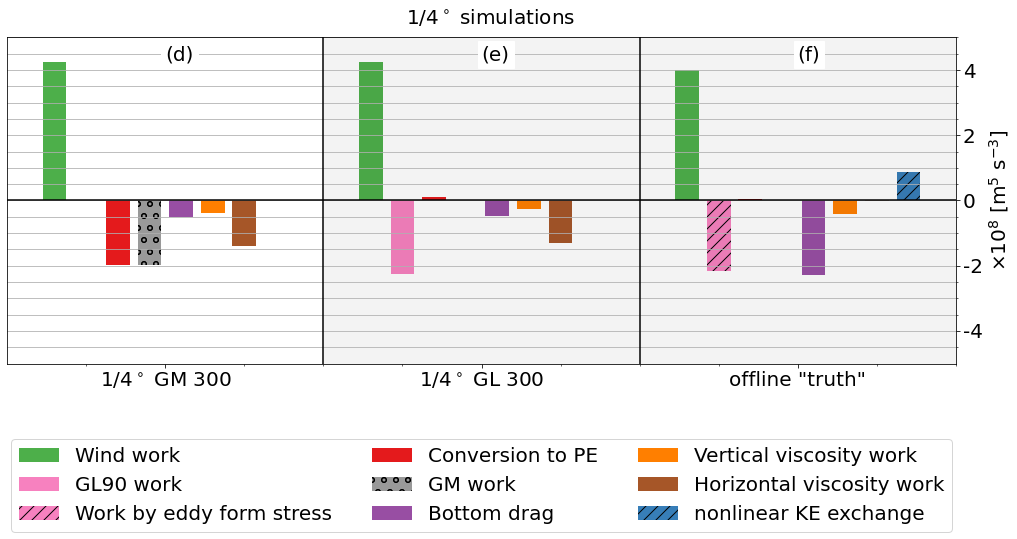

In [24]:
fig = bar_plot_KE_budget(vlist, label_list=label_list, abc_list=abc_list, title=title, ylim=5e8)
figname = '/glade/u/home/noraloose/GL90paper/figures/KE_budget_0.25deg.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree

In [25]:
vlist = [
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_offline['nw2_0.03125deg_N15_baseline_hmix20_fac16']
]
label_list = [
    r'1/8$^\circ$ GM 100',
    r'1/8$^\circ$ GL 100',    
    r'offline "truth"'
]
abc_list =[
    '(g)', '(h)', '(i)'
]
title=r'1/8$^\circ$ simulations'

In [26]:
for v in vlist:
    print(v['label'])
    ds = v['ds']
    #print(len(ds.time))
    #print(ds.time[0].values)
    
    dst = v['dst']
    st = v['st']
    if 'KE_visc_gl90' in dst:
        value = (dst['KE_visc_gl90'].sum(dim='zl') * st.area_t).sum(dim=['xh', 'yh'])
        print('KE_visc_gl90: integral %g' % value)        
    if 'dst_energy' in v:
        dst = v['dst_energy']
        if 'EKE_production_TWA' in dst:
            value = (dst['EKE_production_TWA'] * st.area_t).sum(dim=['xh', 'yh'])
            print('EKE_production_TWA: integral %g' % value)

1/8$^\circ$ GM 100
KE_visc_gl90: integral 8.79636e-10
1/8$^\circ$ GL 100 hbbl 5
KE_visc_gl90: integral -1.33344e+08
1/8$^\circ$ diagnosed
EKE_production_TWA: integral 1.29493e+08


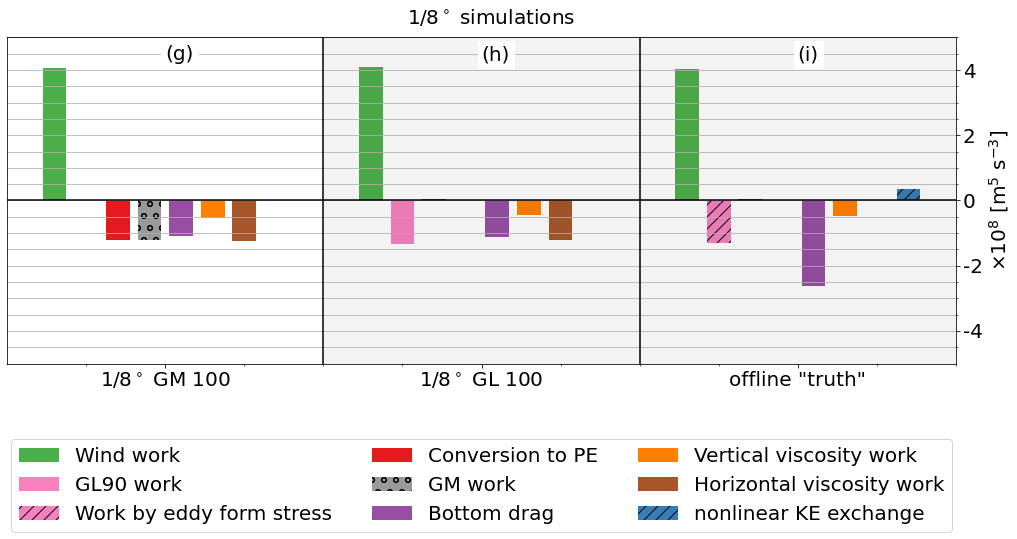

In [27]:
fig = bar_plot_KE_budget(vlist, label_list=label_list, abc_list=abc_list, title=title, ylim=5e8)
figname = '/glade/u/home/noraloose/GL90paper/figures/KE_budget_0.125deg.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)